# Fait par:
    -DIGUIRI Gochede
    -NGANGOM Arnella 
Test du NN AlphaPose avec image ou vidéos.

Fonction pour tester le modèle sur image,video ou webcam. Il suffit de changer la variable FILENAME par le nom du fichier image ou video a ouvrir .
Il faut redemarrer le noyau et re executer si une modification n'est pas prise en compte

In [1]:
!git clone https://github.com/diguiri/test_alphapose.git
!gdown --id 1OPORTWB2cwd5YTVBX-NE8fsauZJWsrtW 
!cp /content/duc_se.pth /content/test_alphapose/models/sppe
!gdown --id 1D47msNOOiJKvPOXlnpyzdKA3k6E97NTC
!cp /content/yolov3-spp.weights /content/test_alphapose/models/yolo

Cloning into 'test_alphapose'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 166 (delta 21), reused 151 (delta 13), pack-reused 0
Receiving objects: 100% (166/166), 29.63 MiB | 42.19 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Downloading...
From: https://drive.google.com/uc?id=1OPORTWB2cwd5YTVBX-NE8fsauZJWsrtW
To: /content/duc_se.pth
239MB [00:01, 174MB/s]
Downloading...
From: https://drive.google.com/uc?id=1D47msNOOiJKvPOXlnpyzdKA3k6E97NTC
To: /content/yolov3-spp.weights
252MB [00:03, 73.7MB/s]


In [2]:
%cd /content/test_alphapose

/content/test_alphapose


In [3]:
!pip install -r requirements.txt

     |████████████████████████████████| 484.0MB 34kB/s 
     |████████████████████████████████| 51kB 10.1MB/s 
     |████████████████████████████████| 686kB 61.7MB/s 
ERROR: Could not find a version that satisfies the requirement ntpath (from -r requirements.txt (line 9)) (from versions: none)
ERROR: No matching distribution found for ntpath (from -r requirements.txt (line 9))


<VideoCapture 0x7f3dca921f70>
Loading YOLO model..
Loading pose model from ./models/sppe/duc_se.pth
Starting demo, press Ctrl + C to terminate...


8it [00:00, 10.40it/s]

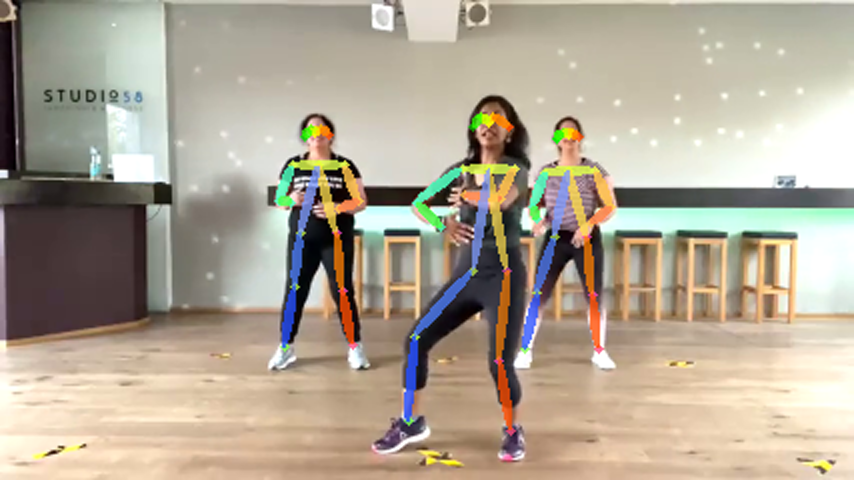

14it [00:01,  9.26it/s]

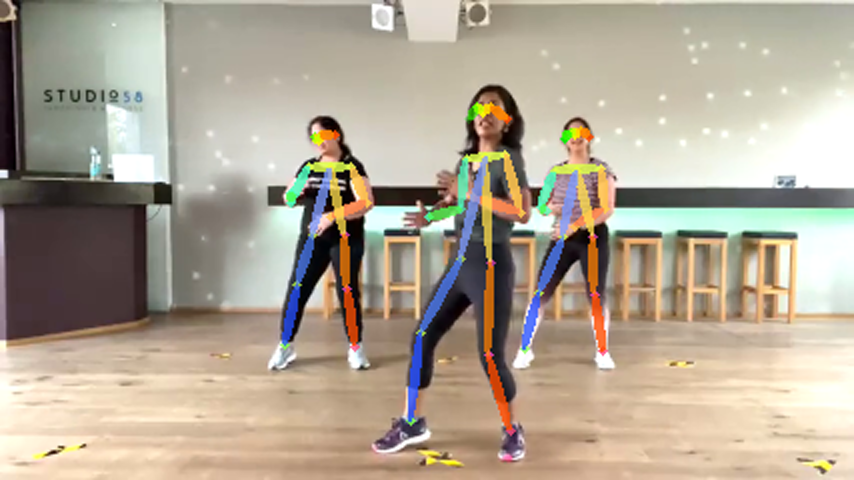

20it [00:02,  7.42it/s]

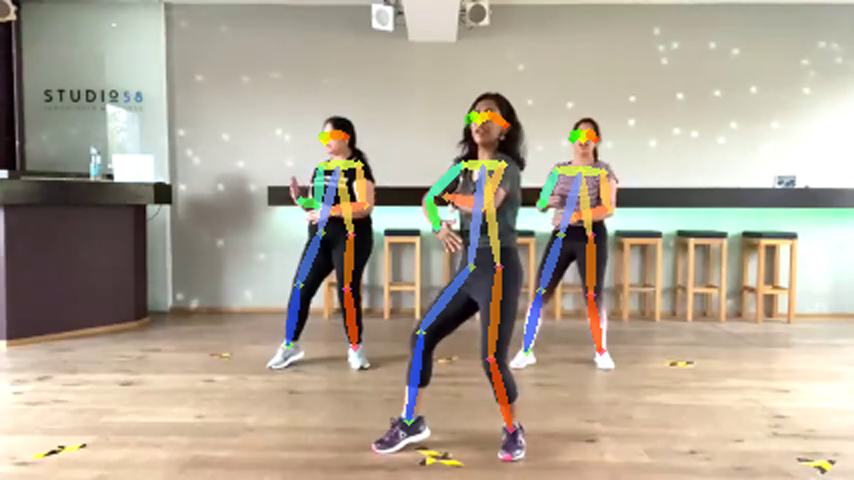

27it [00:03,  8.92it/s]

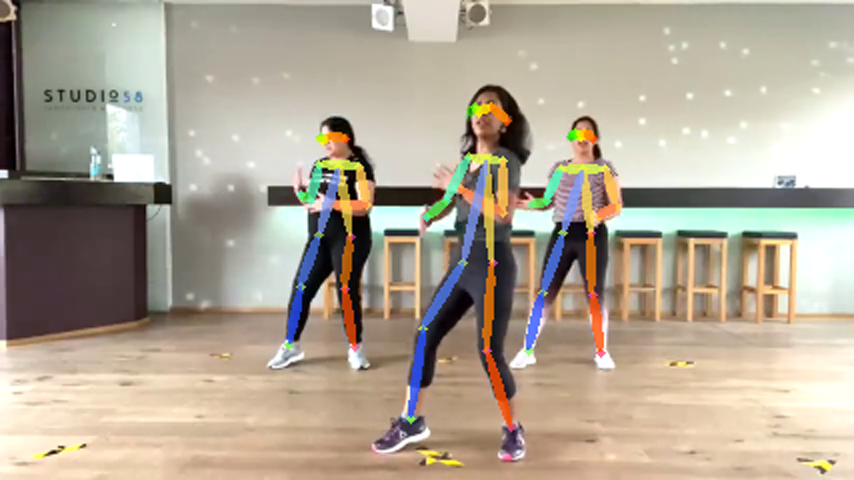

32it [00:03,  7.80it/s]

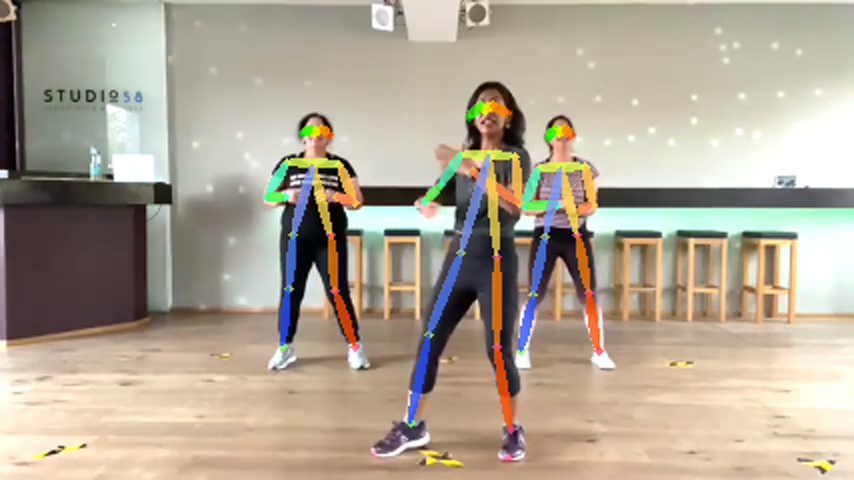

37it [00:04,  7.80it/s]

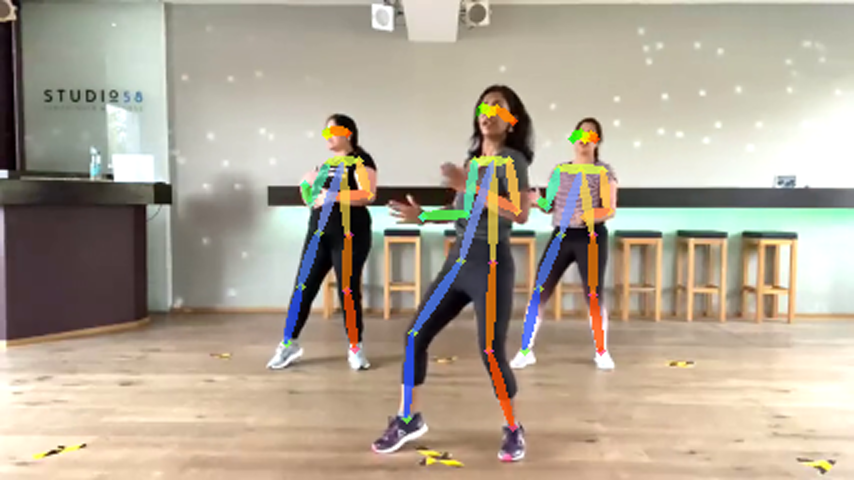

46it [00:05,  8.95it/s]

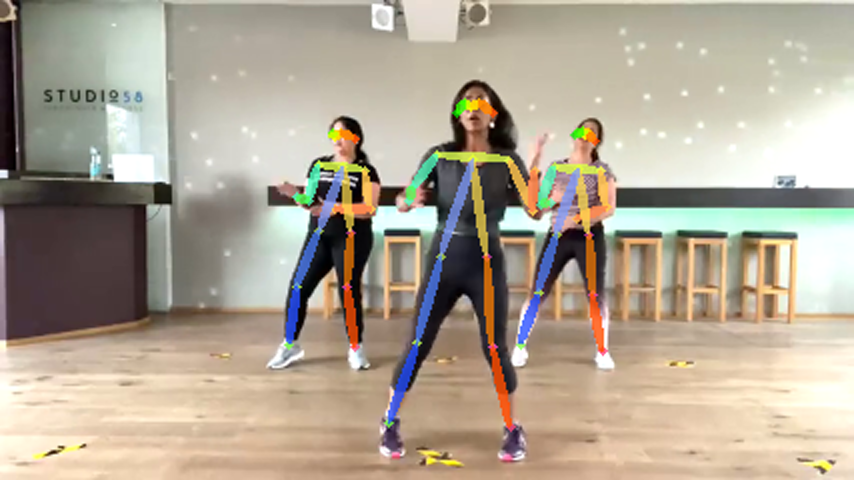

53it [00:06,  8.44it/s]

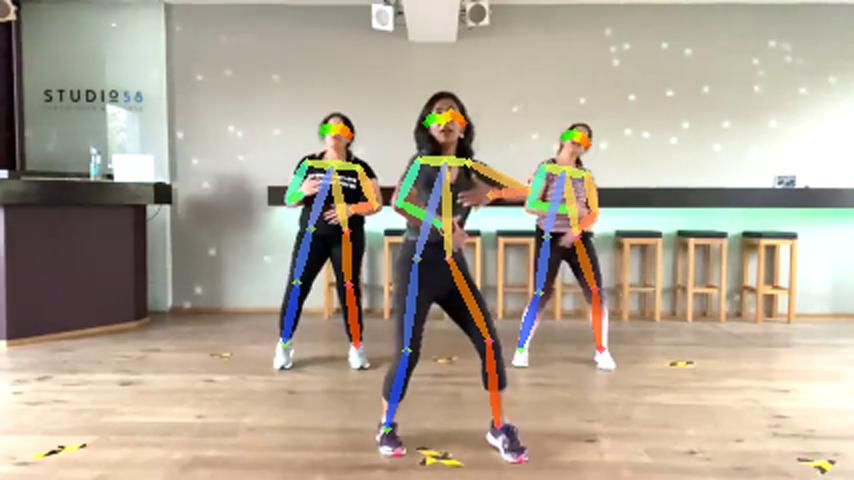

59it [00:06,  8.30it/s]

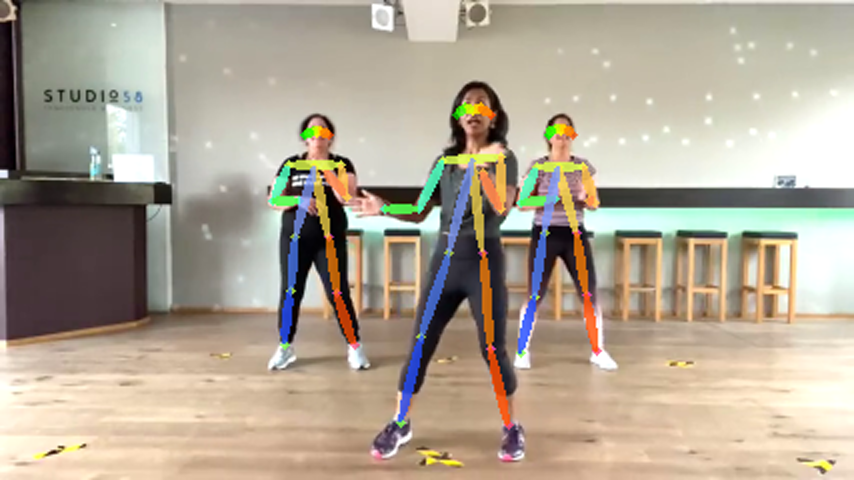

65it [00:07,  7.77it/s]

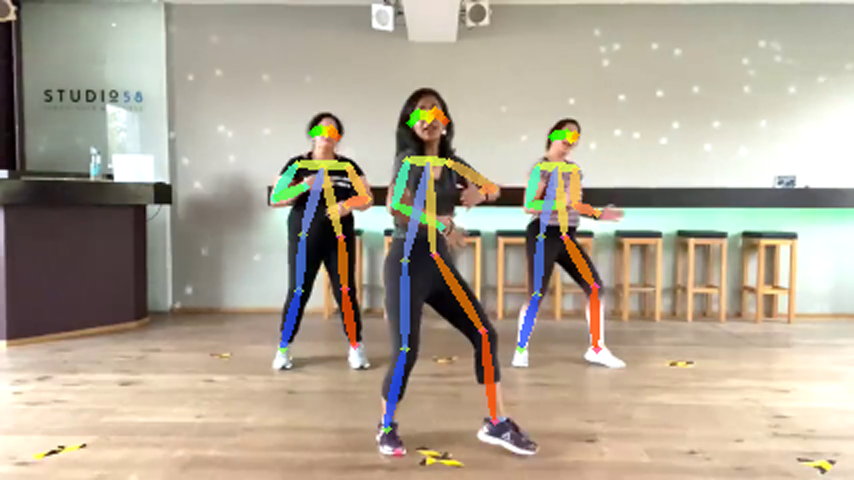

73it [00:08,  8.77it/s]

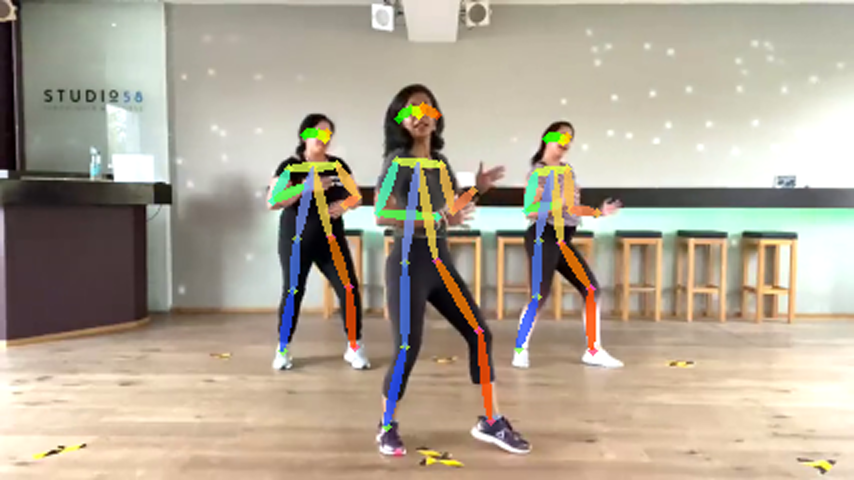

81it [00:09,  8.29it/s]

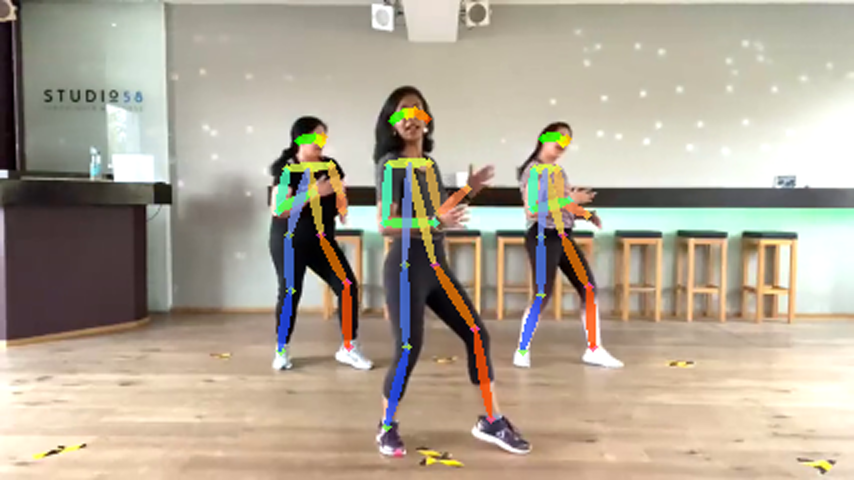

88it [00:10,  8.34it/s]

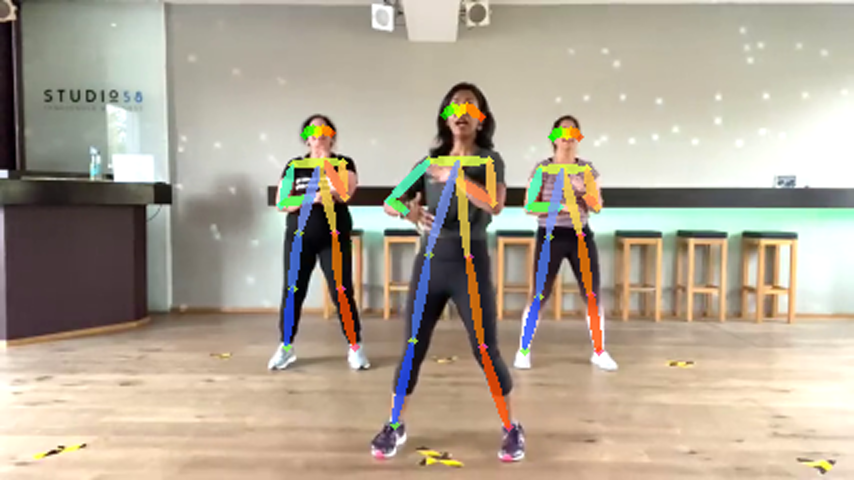

99it [00:11,  7.90it/s]

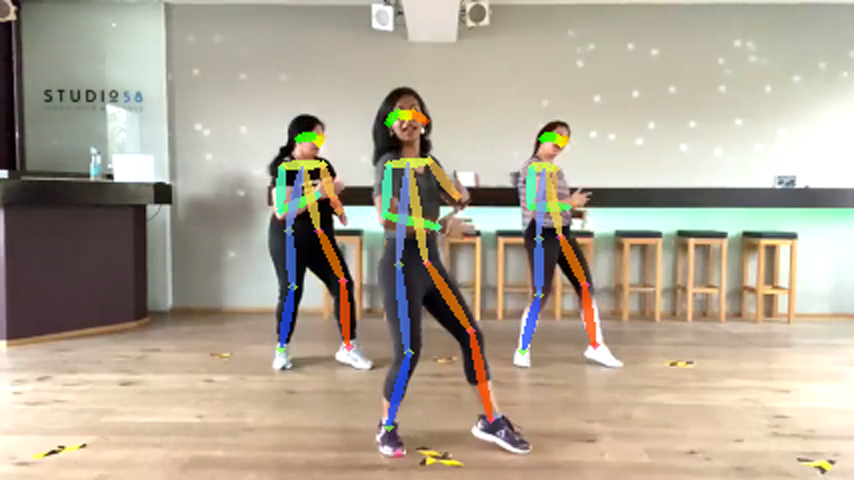

107it [00:13,  7.71it/s]

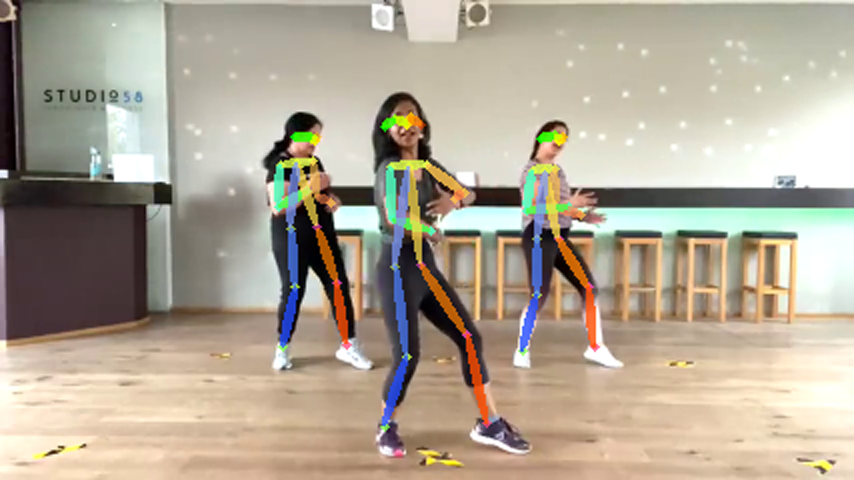

114it [00:13,  7.56it/s]

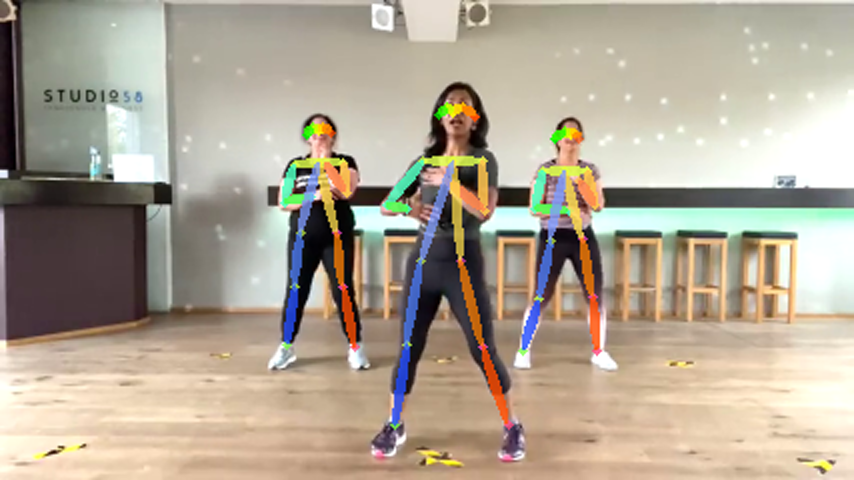

118it [00:14,  6.96it/s]

KeyboardInterrupt: ignored

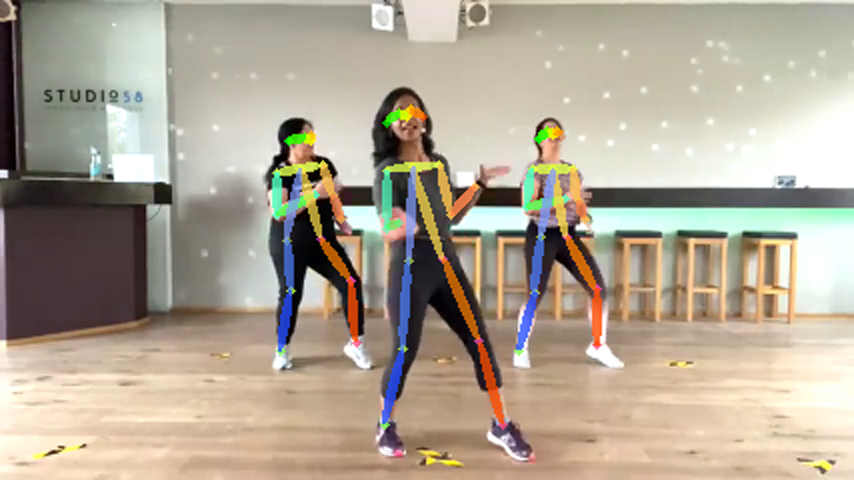

In [3]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms as transforms

import torch.nn as nn
import torch.utils.data
import numpy as np
from opt import opt

from dataloader_webcam import WebcamLoader, DetectionLoader, DetectionProcessor, DataWriter, crop_from_dets, Mscoco
from yolo.darknet import Darknet
from yolo.util import write_results, dynamic_write_results
from SPPE.src.main_fast_inference import *

from SPPE.src.utils.img import im_to_torch
import os
import sys
from tqdm import tqdm
import time
from fn import getTime
import cv2

from pPose_nms import write_json

args = opt
args.dataset = 'coco'
FILENAME = "test.MP4"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def loop():
    n = 0
    while True:
        yield n
        n += 1

if __name__ == "__main__":
    webcam = ""
    
    mode = args.mode
    if not os.path.exists(args.outputpath):
        os.mkdir(args.outputpath)

    # chargement de l'entrée vidéo
    data_loader = WebcamLoader(FILENAME).start()
    (fourcc,fps,frameSize) = data_loader.videoinfo()

    # Chargement de YOLO pour cibler les personnes
    print('Loading YOLO model..')
    sys.stdout.flush()
    det_loader = DetectionLoader(data_loader, batchSize=args.detbatch).start()
    det_processor = DetectionProcessor(det_loader).start()
    
    # Chargememnt du modèle
    pose_dataset = Mscoco()
    if args.fast_inference:
        pose_model = InferenNet_fast(4 * 1 + 1, pose_dataset)
    else:
        pose_model = InferenNet(4 * 1 + 1, pose_dataset)
    pose_model.to(device)
    pose_model.eval()

    # En cas d'enregistrement, il faudra modifier le fichier de parametres opt.py 
    save_path = os.path.join(args.outputpath, 'AlphaPose_webcam'+webcam+'.avi')
    writer = DataWriter(args.save_video, save_path, cv2.VideoWriter_fourcc(*'XVID'), fps, frameSize).start()

    runtime_profile = {
        'dt': [],
        'pt': [],
        'pn': []
    }

    print('Starting demo, press Ctrl + C to terminate...')
    sys.stdout.flush()
    im_names_desc =  tqdm(loop())
    batchSize = args.posebatch
    
    #boucle d'inférence
    for i in im_names_desc:
        try:
            start_time = getTime()
            with torch.no_grad():
                (inps, orig_img, im_name, boxes, scores, pt1, pt2) = det_processor.read()
                if boxes is None or boxes.nelement() == 0:
                    writer.save(None, None, None, None, None, orig_img, im_name.split('/')[-1])
                    continue

                ckpt_time, det_time = getTime(start_time)
                runtime_profile['dt'].append(det_time)
                # Pose Estimation
                
                datalen = inps.size(0)
                leftover = 0
                if (datalen) % batchSize:
                    leftover = 1
                num_batches = datalen // batchSize + leftover
                hm = []
                for j in range(num_batches):
                    inps_j = inps[j*batchSize:min((j +  1)*batchSize, datalen)].to(device)
                    hm_j = pose_model(inps_j)
                    hm.append(hm_j)
                hm = torch.cat(hm)
                ckpt_time, pose_time = getTime(ckpt_time)
                runtime_profile['pt'].append(pose_time)

                hm = hm.cpu().data
                writer.save(boxes, scores, hm, pt1, pt2, orig_img, im_name.split('/')[-1])

                ckpt_time, post_time = getTime(ckpt_time)
                runtime_profile['pn'].append(post_time)
            if args.profile:
                # TQDM
                im_names_desc.set_description(
                'det time: {dt:.3f} | pose time: {pt:.2f} | post processing: {pn:.4f}'.format(
                    dt=np.mean(runtime_profile['dt']), pt=np.mean(runtime_profile['pt']), pn=np.mean(runtime_profile['pn']))
                )
        except KeyboardInterrupt:
            break

    print(' ')
    print('===========================> Finish Model Running.')
    if (args.save_img or args.save_video) and not args.vis_fast:
        print('===========================> Rendering remaining images in the queue...')
        print('===========================> If this step takes too long, you can enable the --vis_fast flag to use fast rendering (real-time).')
    while(writer.running()):
        pass
    writer.stop()
    final_result = writer.results()
    write_json(final_result, args.outputpath)


In [ ]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms as transforms

import torch.nn as nn
import torch.utils.data
import numpy as np
from opt import opt

from dataloader_webcam import WebcamLoader, DetectionLoader, DetectionProcessor, DataWriter, crop_from_dets, Mscoco
from yolo.darknet import Darknet
from yolo.util import write_results, dynamic_write_results
from SPPE.src.main_fast_inference import *

from SPPE.src.utils.img import im_to_torch
import os
import sys
from tqdm import tqdm
import time
from fn import getTime
import cv2

from pPose_nms import write_json

args = opt
args.dataset = 'coco'
FILENAME = "test.MP4"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def loop():
    n = 0
    while True:
        yield n
        n += 1

if __name__ == "__main__":
    webcam = ""
    
    mode = args.mode
    if not os.path.exists(args.outputpath):
        os.mkdir(args.outputpath)

    # chargement de l'entrée vidéo
    data_loader = WebcamLoader(FILENAME).start()
    (fourcc,fps,frameSize) = data_loader.videoinfo()

    # Chargement de YOLO pour cibler les personnes
    print('Loading YOLO model..')
    sys.stdout.flush()
    det_loader = DetectionLoader(data_loader, batchSize=args.detbatch).start()
    det_processor = DetectionProcessor(det_loader).start()
    
    # Chargememnt du modèle
    pose_dataset = Mscoco()
    if args.fast_inference:
        pose_model = InferenNet_fast(4 * 1 + 1, pose_dataset)
    else:
        pose_model = InferenNet(4 * 1 + 1, pose_dataset)
    pose_model.to(device)
    pose_model.eval()

    # En cas d'enregistrement, il faudra modifier le fichier de parametres opt.py 
    save_path = os.path.join(args.outputpath, 'AlphaPose_webcam'+webcam+'.avi')
    writer = DataWriter(args.save_video, save_path, cv2.VideoWriter_fourcc(*'XVID'), fps, frameSize).start()

    runtime_profile = {
        'dt': [],
        'pt': [],
        'pn': []
    }

    print('Starting demo, press Ctrl + C to terminate...')
    sys.stdout.flush()
    im_names_desc =  tqdm(loop())
    batchSize = args.posebatch
    
    #boucle d'inférence
    for i in im_names_desc:
        try:
            start_time = getTime()
            with torch.no_grad():
                (inps, orig_img, im_name, boxes, scores, pt1, pt2) = det_processor.read()
                if boxes is None or boxes.nelement() == 0:
                    writer.save(None, None, None, None, None, orig_img, im_name.split('/')[-1])
                    continue

                ckpt_time, det_time = getTime(start_time)
                runtime_profile['dt'].append(det_time)
                # Pose Estimation
                
                datalen = inps.size(0)
                leftover = 0
                if (datalen) % batchSize:
                    leftover = 1
                num_batches = datalen // batchSize + leftover
                hm = []
                for j in range(num_batches):
                    inps_j = inps[j*batchSize:min((j +  1)*batchSize, datalen)].to(device)
                    hm_j = pose_model(inps_j)
                    hm.append(hm_j)
                hm = torch.cat(hm)
                ckpt_time, pose_time = getTime(ckpt_time)
                runtime_profile['pt'].append(pose_time)

                hm = hm.cpu().data
                writer.save(boxes, scores, hm, pt1, pt2, orig_img, im_name.split('/')[-1])

                ckpt_time, post_time = getTime(ckpt_time)
                runtime_profile['pn'].append(post_time)
            if args.profile:
                # TQDM
                im_names_desc.set_description(
                'det time: {dt:.3f} | pose time: {pt:.2f} | post processing: {pn:.4f}'.format(
                    dt=np.mean(runtime_profile['dt']), pt=np.mean(runtime_profile['pt']), pn=np.mean(runtime_profile['pn']))
                )
        except KeyboardInterrupt:
            break

    print(' ')
    print('===========================> Finish Model Running.')
    if (args.save_img or args.save_video) and not args.vis_fast:
        print('===========================> Rendering remaining images in the queue...')
        print('===========================> If this step takes too long, you can enable the --vis_fast flag to use fast rendering (real-time).')
    while(writer.running()):
        pass
    writer.stop()
    final_result = writer.results()
    write_json(final_result, args.outputpath)


<VideoCapture 0x7f1d4252ae50>
Loading YOLO model..


RuntimeError: ignored

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms as transforms

import torch.nn as nn
import torch.utils.data
import numpy as np
from opt import opt

from dataloader_webcam import WebcamLoader, DetectionLoader, DetectionProcessor, DataWriter, crop_from_dets, Mscoco
from yolo.darknet import Darknet
from yolo.util import write_results, dynamic_write_results
from SPPE.src.main_fast_inference import *

from SPPE.src.utils.img import im_to_torch
import os
import sys
from tqdm import tqdm
import time
from fn import getTime
import cv2

from pPose_nms import write_json

args = opt
args.dataset = 'coco'
FILENAME = "test.MP4"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def loop():
    n = 0
    while True:
        yield n
        n += 1

if __name__ == "__main__":
    webcam = ""
    
    mode = args.mode
    if not os.path.exists(args.outputpath):
        os.mkdir(args.outputpath)

    # chargement de l'entrée vidéo
    data_loader = WebcamLoader(FILENAME).start()
    (fourcc,fps,frameSize) = data_loader.videoinfo()

    # Chargement de YOLO pour cibler les personnes
    print('Loading YOLO model..')
    sys.stdout.flush()
    det_loader = DetectionLoader(data_loader, batchSize=args.detbatch).start()
    det_processor = DetectionProcessor(det_loader).start()
    
    # Chargememnt du modèle
    pose_dataset = Mscoco()
    if args.fast_inference:
        pose_model = InferenNet_fast(4 * 1 + 1, pose_dataset)
    else:
        pose_model = InferenNet(4 * 1 + 1, pose_dataset)
    pose_model.to(device)
    pose_model.eval()

    # En cas d'enregistrement, il faudra modifier le fichier de parametres opt.py 
    save_path = os.path.join(args.outputpath, 'AlphaPose_webcam'+webcam+'.avi')
    writer = DataWriter(args.save_video, save_path, cv2.VideoWriter_fourcc(*'XVID'), fps, frameSize).start()

    runtime_profile = {
        'dt': [],
        'pt': [],
        'pn': []
    }

    print('Starting demo, press Ctrl + C to terminate...')
    sys.stdout.flush()
    im_names_desc =  tqdm(loop())
    batchSize = args.posebatch
    
    #boucle d'inférence
    for i in im_names_desc:
        try:
            start_time = getTime()
            with torch.no_grad():
                (inps, orig_img, im_name, boxes, scores, pt1, pt2) = det_processor.read()
                if boxes is None or boxes.nelement() == 0:
                    writer.save(None, None, None, None, None, orig_img, im_name.split('/')[-1])
                    continue

                ckpt_time, det_time = getTime(start_time)
                runtime_profile['dt'].append(det_time)
                # Pose Estimation
                
                datalen = inps.size(0)
                leftover = 0
                if (datalen) % batchSize:
                    leftover = 1
                num_batches = datalen // batchSize + leftover
                hm = []
                for j in range(num_batches):
                    inps_j = inps[j*batchSize:min((j +  1)*batchSize, datalen)].to(device)
                    hm_j = pose_model(inps_j)
                    hm.append(hm_j)
                hm = torch.cat(hm)
                ckpt_time, pose_time = getTime(ckpt_time)
                runtime_profile['pt'].append(pose_time)

                hm = hm.cpu().data
                writer.save(boxes, scores, hm, pt1, pt2, orig_img, im_name.split('/')[-1])

                ckpt_time, post_time = getTime(ckpt_time)
                runtime_profile['pn'].append(post_time)
            if args.profile:
                # TQDM
                im_names_desc.set_description(
                'det time: {dt:.3f} | pose time: {pt:.2f} | post processing: {pn:.4f}'.format(
                    dt=np.mean(runtime_profile['dt']), pt=np.mean(runtime_profile['pt']), pn=np.mean(runtime_profile['pn']))
                )
        except KeyboardInterrupt:
            break

    print(' ')
    print('===========================> Finish Model Running.')
    if (args.save_img or args.save_video) and not args.vis_fast:
        print('===========================> Rendering remaining images in the queue...')
        print('===========================> If this step takes too long, you can enable the --vis_fast flag to use fast rendering (real-time).')
    while(writer.running()):
        pass
    writer.stop()
    final_result = writer.results()
    write_json(final_result, args.outputpath)


<VideoCapture 0x7f1d4252ae50>
Loading YOLO model..


RuntimeError: ignored

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms as transforms

import torch.nn as nn
import torch.utils.data
import numpy as np
from opt import opt

from dataloader_webcam import WebcamLoader, DetectionLoader, DetectionProcessor, DataWriter, crop_from_dets, Mscoco
from yolo.darknet import Darknet
from yolo.util import write_results, dynamic_write_results
from SPPE.src.main_fast_inference import *

from SPPE.src.utils.img import im_to_torch
import os
import sys
from tqdm import tqdm
import time
from fn import getTime
import cv2

from pPose_nms import write_json

args = opt
args.dataset = 'coco'
FILENAME = "test.MP4"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def loop():
    n = 0
    while True:
        yield n
        n += 1

if __name__ == "__main__":
    webcam = ""
    
    mode = args.mode
    if not os.path.exists(args.outputpath):
        os.mkdir(args.outputpath)

    # chargement de l'entrée vidéo
    data_loader = WebcamLoader(FILENAME).start()
    (fourcc,fps,frameSize) = data_loader.videoinfo()

    # Chargement de YOLO pour cibler les personnes
    print('Loading YOLO model..')
    sys.stdout.flush()
    det_loader = DetectionLoader(data_loader, batchSize=args.detbatch).start()
    det_processor = DetectionProcessor(det_loader).start()
    
    # Chargememnt du modèle
    pose_dataset = Mscoco()
    if args.fast_inference:
        pose_model = InferenNet_fast(4 * 1 + 1, pose_dataset)
    else:
        pose_model = InferenNet(4 * 1 + 1, pose_dataset)
    pose_model.to(device)
    pose_model.eval()

    # En cas d'enregistrement, il faudra modifier le fichier de parametres opt.py 
    save_path = os.path.join(args.outputpath, 'AlphaPose_webcam'+webcam+'.avi')
    writer = DataWriter(args.save_video, save_path, cv2.VideoWriter_fourcc(*'XVID'), fps, frameSize).start()

    runtime_profile = {
        'dt': [],
        'pt': [],
        'pn': []
    }

    print('Starting demo, press Ctrl + C to terminate...')
    sys.stdout.flush()
    im_names_desc =  tqdm(loop())
    batchSize = args.posebatch
    
    #boucle d'inférence
    for i in im_names_desc:
        try:
            start_time = getTime()
            with torch.no_grad():
                (inps, orig_img, im_name, boxes, scores, pt1, pt2) = det_processor.read()
                if boxes is None or boxes.nelement() == 0:
                    writer.save(None, None, None, None, None, orig_img, im_name.split('/')[-1])
                    continue

                ckpt_time, det_time = getTime(start_time)
                runtime_profile['dt'].append(det_time)
                # Pose Estimation
                
                datalen = inps.size(0)
                leftover = 0
                if (datalen) % batchSize:
                    leftover = 1
                num_batches = datalen // batchSize + leftover
                hm = []
                for j in range(num_batches):
                    inps_j = inps[j*batchSize:min((j +  1)*batchSize, datalen)].to(device)
                    hm_j = pose_model(inps_j)
                    hm.append(hm_j)
                hm = torch.cat(hm)
                ckpt_time, pose_time = getTime(ckpt_time)
                runtime_profile['pt'].append(pose_time)

                hm = hm.cpu().data
                writer.save(boxes, scores, hm, pt1, pt2, orig_img, im_name.split('/')[-1])

                ckpt_time, post_time = getTime(ckpt_time)
                runtime_profile['pn'].append(post_time)
            if args.profile:
                # TQDM
                im_names_desc.set_description(
                'det time: {dt:.3f} | pose time: {pt:.2f} | post processing: {pn:.4f}'.format(
                    dt=np.mean(runtime_profile['dt']), pt=np.mean(runtime_profile['pt']), pn=np.mean(runtime_profile['pn']))
                )
        except KeyboardInterrupt:
            break

    print(' ')
    print('===========================> Finish Model Running.')
    if (args.save_img or args.save_video) and not args.vis_fast:
        print('===========================> Rendering remaining images in the queue...')
        print('===========================> If this step takes too long, you can enable the --vis_fast flag to use fast rendering (real-time).')
    while(writer.running()):
        pass
    writer.stop()
    final_result = writer.results()
    write_json(final_result, args.outputpath)


<VideoCapture 0x7f1d4252ae50>
Loading YOLO model..


RuntimeError: ignored